### 20221116作业：

**袁靖松-3200105467**

基于课堂展示的“机器学习选股范例”代码进行改造：

作业可使用Jupyter Notebook完成，请大家独立完成。作业提交日期为2022年11月30日，请将作业分别交给所在组的助教。

In [1]:
#导入包
import numpy as np
import pandas as pd

In [2]:
## 定义参数类
#-- define a class including all parameters
class Para():
    
    method = 'XGBOOST-C' # 'LOGI' 'XGBOOST-C' 'LR'  
    
    month_in_sample = range(82,153+1) #-- return 82~153 72 months
    month_test = range(154,293+1) #-- return 154~293 140 months
    
    percent_select = [0.3,0.3] #-- 30% positive samples, 30% negative samples
    percent_cv = 0.1 #-- percentage of cross validation samples 交叉验证的样本比例
    
    path_data = './data/csv_demo/'
    path_results = './results/'
    
    seed = 42 #-- random seed
    n_stock=5166
    logi_c = 0.0006 #-- logistic regression parameter         #逻辑回归中正则化系数λ的倒数，越小的数值表示越强的正则化
    
    xgbc_n_estimators = 100 #-- xgboost classifier parameter  #迭代次数，即树的个数
    xgbc_learning_rate = 0.1 #-- xgboost classifier parameter #通过减小每一步的权重，可以提高模型的Robust
    xgbc_subsample_C = 0.95 #-- xgboost classifier parameter  #控制对于每棵树随机采样的比例。减小这个参数的值，可以避免过拟合。但如果设置得过小，可能会导致欠拟合。
    xgbc_max_depth = 3 #-- xgboost classifier parameter       #树的最大深度，避免过拟合，max_depth越大，模型会学到更具体更局部的样本，需要使用CV函数来进行调优；

para = Para()

In [3]:
## 生成二分类标签函数
#-- function, label data 
def label_data(data):
    #-- label data
    data['return_bin'] = np.nan
    
    #-- sort by return
    data = data.sort_values(by='return',ascending=False)
    
    #-- decide the amount of stocks selected
    n_stock_select = np.multiply(para.percent_select,data.shape[0]) #计算矩阵的内积
    n_stock_select = np.around(n_stock_select).astype(int) #结果为整数
    
    #-- assign 1 or 0
    data.iloc[0:n_stock_select[0],-1] = 1  
    data.iloc[-n_stock_select[1]:,-1] = 0
    
    #-- remove other stocks
    data = data.dropna(axis=0)
    
    return data

## 1. 原始代码为静态训练，可否改成滚动训练，如每次使用最近N个月数据训练，每半年更新一次模型？（提示：增加循环即可）

In [4]:
#设置滚动训练时间
train_data_min_months=72                      #每次模型训练所用数据最少不低于
train_data_max_months=108                     #每次模型训练所用数据最大不超过
train_update_months=6                         #设置更新周期
start_date = 82                               #第一次滚动训练开始日期
end_date = start_date + train_data_min_months #第一次滚动训练结束日期

i=0

## 样本外预测
#-- predict

d=pd.DataFrame([np.nan] * np.zeros((para.n_stock,end_date)))
y_true_test=d
y_pred_test=d
y_score_test=d

while end_date<= 293:
    period_train=range(start_date,end_date+1)
    
    ## 生成样本内数据集
    #-- generate in-sample data
    for i_month in period_train:
        #-- load csv
        file_name = para.path_data + str(i_month) + '.csv'
        data_curr_month = pd.read_csv(file_name, header = 0)#设置表头
        para.n_stock = data_curr_month.shape[0]

        #-- remove nan
        data_curr_month = data_curr_month.dropna(axis=0)

        #-- label data    
        data_curr_month = label_data(data_curr_month) #调用函数，

        #-- merge
        if i_month == period_train[0]: #-- first month
            data_in_sample = data_curr_month
        else:
            data_in_sample = pd.concat((data_in_sample,data_curr_month), axis=0)
    
    # 样本内数据集
    #-- generate in-sample data
    X_in_sample = data_in_sample.loc[:,'EP':'bias'] #提取数据

    #-- classification
    if para.method in ['LOGI','XGBOOST-C']:
        y_in_sample = data_in_sample.loc[:,'return_bin']

    #-- regression
    if para.method in ['LR']:
        y_in_sample = data_in_sample.loc[:,'return']
        
    ## 划分训练集和验证集
    #-- generate train and cv data
    from sklearn.model_selection import train_test_split

    #随机拆分数据为train set训练集和test set测试集
    #X:要划分的样本特征集（输入的信息）
    #y:需要划分的样本结果（输出结果）
    #test_size:样本占比，测试集在总数中的百分比（小数表示）
    #random_state:随机数种子，对于模型分割，必须用同一随机数种子，保证每次随机分割后数据集不变。

    if para.percent_cv > 0:  
        X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)
    else:
        X_train, y_train = X_in_sample.copy(), y_in_sample.copy()
    
    ## 设置模型
    #-- set model
    #有监督，输出是分类型数据，逻辑回归
    #-- logistic regression
    if para.method == 'LOGI':
        from sklearn import linear_model
        model = linear_model.LogisticRegression(C=para.logi_c)

    #集成算法
    #-- XGBoost Classifier 分类
    if para.method == 'XGBOOST-C':
        from xgboost import XGBClassifier
        model = XGBClassifier(random_state=para.seed, 
                              n_estimators=para.xgbc_n_estimators,   #迭代次数
                              learning_rate=para.xgbc_learning_rate, #减小每一步的权重，提高robust
                              subsample=para.xgbc_subsample_C,       #随机采样比例
                              max_depth=para.xgbc_max_depth)         #控制深度，避免过拟合
    #有监督，连续型数据
    #-- linear regression
    if para.method == 'LR':
        from sklearn import linear_model
        model = linear_model.LinearRegression(fit_intercept=True)    #计算偏置 
    ## 训练模型，交叉验证
    #-- train model, and perform cross validation
    #-- classification
    if para.method in ['LOGI','XGBOOST-C']:
        model.fit(X_train,y_train)  #投入训练数据，fit()函数
        #-- y_pred: binary format; y_score: continious format
        y_pred_train = model.predict(X_train)  #预测输出结果，得到预测类别结果
        y_score_train = model.predict_proba(X_train)[:,1] #得到预测概率

        if para.percent_cv > 0:  #0.1比例的验证集
            y_pred_cv = model.predict(X_cv)
            y_score_cv = model.predict_proba(X_cv)[:,1] 
            # 返回预测属于某标签的概率  

    #-- regression
    if para.method in ['LR']:
        model.fit(X_train,y_train)
        y_score_train = model.predict(X_train)

        if para.percent_cv > 0:
            y_score_cv = model.predict(X_cv)
    
    ##样本外预测集   
    test_date_start = end_date + 1
    test_date_end = end_date + 6
    period_test=range(test_date_start,test_date_end+1)
    
    a=pd.DataFrame([np.nan] * np.zeros((para.n_stock,period_test[-1]+1)))
    b=pd.DataFrame([np.nan] * np.zeros((para.n_stock,period_test[-1]+1)))
    c=pd.DataFrame([np.nan] * np.zeros((para.n_stock,period_test[-1]+1)))
    
    for i_month in period_test:
        #-- load
        file_name = para.path_data + str(i_month) + '.csv'
        data_curr_month = pd.read_csv(file_name, header = 0)
        #-- remove nan  
        data_curr_month = data_curr_month.dropna(axis=0)
        #-- generate X
        X_curr_month = data_curr_month.loc[:,'EP':'bias']
        #-- pca
        #X_curr_month = pca.transform(X_curr_month)
        #-- predict and get predicted probability
        #-- classification
        if para.method in ['LOGI','XGBOOST-C']:
            y_pred_curr_month = model.predict(X_curr_month)
            y_score_curr_month = model.predict_proba(X_curr_month)[:,1]
        #-- linear regression
        if para.method in ['LR',]:
            y_score_curr_month = model.predict(X_curr_month)
        #-- store real and predicted return
        a.iloc[data_curr_month.index,i_month-1] = data_curr_month['return'][data_curr_month.index]
        if para.method in ['LOGI','XGBOOST-C']:
            b.iloc[data_curr_month.index,i_month-1] = y_pred_curr_month
        c.iloc[data_curr_month.index,i_month-1] = y_score_curr_month
    #合并运行生成的数据
    y_true_test=pd.concat([y_true_test,a.iloc[:,-7:-1]],axis=1)
    y_pred_test=pd.concat([y_pred_test,b.iloc[:,-7:-1]],axis=1)
    y_score_test=pd.concat([y_score_test,c.iloc[:,-7:-1]],axis=1)
     
     ## 模型评价
    #-- evaluate
    if para.method in ['LOGI','XGBOOST-C']:
        from sklearn import metrics
        print('training set, accuracy = %.2f'%metrics.accuracy_score(y_train, y_pred_train))
        print('training set, AUC = %.2f'%metrics.roc_auc_score(y_train, y_score_train))
        if para.percent_cv > 0:
            print('cv set, accuracy = %.2f'%metrics.accuracy_score(y_cv, y_pred_cv))
            print('cv set, AUC = %.2f'%metrics.roc_auc_score(y_cv, y_score_cv))
        for i_month in period_test:
            #-- 4 types of y
            #-- y_true_*: true continious
            #-- y_*: true binary
            #-- y_pred_*: predicted binary
            #-- y_score_*: predicted continious
            y_true_curr_month = pd.DataFrame({'return':y_true_test.iloc[:,i_month-1]})
            y_pred_curr_month = y_pred_test.iloc[:,i_month-1]
            y_score_curr_month = y_score_test.iloc[:,i_month-1]
            #-- remove nan
            y_true_curr_month = y_true_curr_month.dropna(axis=0)
            #-- label data
            y_curr_month = label_data(y_true_curr_month)['return_bin']
            #-- only select best and worst 30% data
            y_pred_curr_month = y_pred_curr_month[y_curr_month.index]
            y_score_curr_month = y_score_curr_month[y_curr_month.index]
            print('testing set, month %d, accuracy = %.2f'%(i_month, metrics.accuracy_score(y_curr_month, y_pred_curr_month)))
            print('testing set, month %d, AUC = %.2f'%(i_month, metrics.roc_auc_score(y_curr_month, y_score_curr_month)))
    if para.method in ['LR']:
        y_train.index = range(len(y_train))
        y_score_train = pd.Series(y_score_train)
        print('training set, ic = %.2f'%y_train.corr(y_score_train))
        if para.percent_cv > 0:
            y_cv.index = range(len(y_cv))
            y_score_cv = pd.Series(y_score_cv)
            print('cv set, ic = %.2f'%y_cv.corr(y_score_cv))
        for i_month in period_test:
            y_true_curr_month = y_true_test.iloc[:,i_month-1]
            y_score_curr_month = y_score_test.iloc[:,i_month-1]
            print('testing set, month %d, ic = %.2f'%(i_month, y_true_curr_month.corr(y_score_curr_month)))
      
    ##数据集滚动
    end_date += train_update_months
    if train_data_max_months <= end_date - start_date:
        start_date = end_date - train_data_max_months
    else:
        start_date = start_date
    if end_date+6>=293:
        break


training set, accuracy = 0.61
training set, AUC = 0.65
cv set, accuracy = 0.59
cv set, AUC = 0.62
testing set, month 155, accuracy = 0.59
testing set, month 155, AUC = 0.64
testing set, month 156, accuracy = 0.51
testing set, month 156, AUC = 0.54
testing set, month 157, accuracy = 0.55
testing set, month 157, AUC = 0.59
testing set, month 158, accuracy = 0.58
testing set, month 158, AUC = 0.59
testing set, month 159, accuracy = 0.54
testing set, month 159, AUC = 0.58
testing set, month 160, accuracy = 0.53
testing set, month 160, AUC = 0.56
training set, accuracy = 0.60
training set, AUC = 0.64
cv set, accuracy = 0.58
cv set, AUC = 0.61
testing set, month 161, accuracy = 0.58
testing set, month 161, AUC = 0.63
testing set, month 162, accuracy = 0.56
testing set, month 162, AUC = 0.57
testing set, month 163, accuracy = 0.56
testing set, month 163, AUC = 0.59
testing set, month 164, accuracy = 0.50
testing set, month 164, AUC = 0.51
testing set, month 165, accuracy = 0.62
testing set, m

KeyboardInterrupt: 

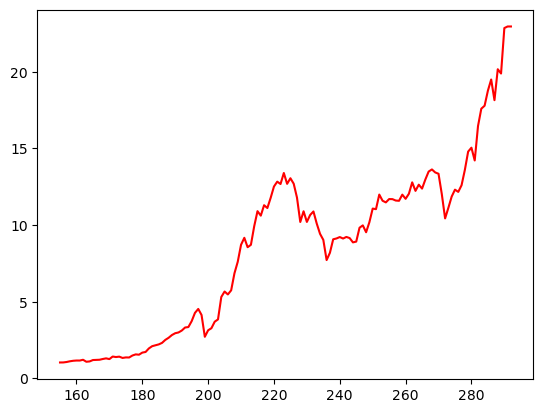

annual excess return = 0.31
annual excess volatility = 0.26
information ratio = 1.17


In [14]:
## 简易回测
#-- simple strategy, select 50 stocks every month, equally weighted
para.n_stock_select = 50
period_test=range(155,293)
strategy = pd.DataFrame({'return':[0] * (period_test[-1]+1),'value':[1] * (period_test[-1]+1)})

for i_month in period_test:
    #-- get real and predicted return
    y_true_curr_month = y_true_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    
    #-- sort predicted return, and choose the best 50
    y_score_curr_month = y_score_curr_month.sort_values(ascending=False)
    index_select = y_score_curr_month[0:para.n_stock_select].index
    
    #-- take the average return as the return of next month
    strategy.loc[i_month-1,'return'] = np.mean(y_true_curr_month[index_select])

    
#-- compute the compund value of the strategy
strategy['value'] = (strategy['return'] + 1).cumprod()

#-- plot the value
import matplotlib.pyplot as plt
plt.plot(range(155,292+1),strategy.loc[range(155,292+1),'value'],'r-')
plt.show()

#-- evaluation
ann_excess_return = np.mean(strategy.loc[period_test,'return']) * 12
ann_excess_vol = np.std(strategy.loc[period_test,'return']) * np.sqrt(12)
info_ratio = ann_excess_return/ann_excess_vol

print('annual excess return = %.2f'%ann_excess_return)
print('annual excess volatility = %.2f'%ann_excess_vol)
print('information ratio = %.2f'%info_ratio)


## 2.原始代码未涉及交叉验证调参，验证集未实际发挥作用，可否添加调参模块？（提示：sklearn有现成工具）

In [5]:
## 生成样本内数据集
#-- generate in-sample data
for i_month in para.month_in_sample:
    #-- load csv
    file_name = para.path_data + str(i_month) + '.csv'
    data_curr_month = pd.read_csv(file_name, header = 0)
    para.n_stock = data_curr_month.shape[0]
    
    #-- remove nan
    data_curr_month = data_curr_month.dropna(axis=0)
    
    #-- label data    
    data_curr_month = label_data(data_curr_month)

    #-- merge
    if i_month == para.month_in_sample[0]: #-- first month
        data_in_sample = data_curr_month
    else:
        data_in_sample = pd.concat((data_in_sample,data_curr_month), axis=0)
# 样本内数据集
#-- generate in-sample data
X_in_sample = data_in_sample.loc[:,'EP':'bias']

#-- classification
if para.method in ['LOGI','XGBOOST-C']:
    y_in_sample = data_in_sample.loc[:,'return_bin']

#-- regression
if para.method in ['LR']:
    y_in_sample = data_in_sample.loc[:,'return']
## 划分训练集和验证集
#-- generate train and cv data
from sklearn.model_selection import train_test_split

if para.percent_cv > 0:
    X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)
else:
    X_train, y_train = X_in_sample.copy(), y_in_sample.copy()
## 设置模型
#-- set model

#-- logistic regression
if para.method == 'LOGI':
    from sklearn import linear_model
    model = linear_model.LogisticRegression(C=para.logi_c)

#-- XGBoost Classifier
if para.method == 'XGBOOST-C':
    from xgboost import XGBClassifier
    model = XGBClassifier(random_state=para.seed,
                          n_estimators=para.xgbc_n_estimators,
                          learning_rate=para.xgbc_learning_rate,
                          subsample=para.xgbc_subsample_C,
                          max_depth=para.xgbc_max_depth)

#-- linear regression
if para.method == 'LR':
    from sklearn import linear_model
    model = linear_model.LinearRegression(fit_intercept=True)

In [6]:
## 训练模型，交叉验证
#-- train model, and perform cross validation
#-- classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

n_folds = 20 # 设置交叉检验的次数
if para.method in ['LOGI','XGBOOST-C']:
    cv_score_list = [] # 交叉检验结果列表
    model.fit(X_train,y_train)
    #-- y_pred: binary format; y_score: continious format
    y_pred_train = model.predict(X_train) 
    y_score_train = model.predict_proba(X_train)[:,1]
    
    if para.percent_cv > 0:
        #交叉验证
        y_pred_cv = model.predict(X_cv)
        y_score_cv = model.predict_proba(X_cv)[:,1]
        scores = cross_val_score(model, X_cv, y_cv, cv = n_folds,scoring = 'r2')
        cv_score_list.append(scores)
        #调参
        learning_rate = [0.01,0.1,0.2,0.3] #学习率
        gamma = [1, 0.1, 0.01,]
        max_depth=[2,3,4]

        param_grid = dict(learning_rate = learning_rate,gamma = gamma,max_depth=max_depth)#转化为字典格式，网络搜索要求
        model_gs = GridSearchCV(model, param_grid ,scoring = 'neg_log_loss',n_jobs = -1,cv=5)
        model_gs.fit(X_train,y_train)
        print(cv_score_list)
        print('Best score is:',model_gs.best_score_) 
        print('Best parameter is:',model_gs.best_params_)   
        
#-- regression
if para.method in ['LR']:
    model.fit(X_train,y_train)
    y_score_train = model.predict(X_train)
    
    if para.percent_cv > 0:
        y_score_cv = model.predict(X_cv)
        scores = cross_val_score(model, X_cv, y_cv, cv = n_folds,scoring = 'r2')
        cv_score_list.append(scores)

[array([-0.78815789, -0.6027193 , -0.61596491, -0.78075055, -0.78075055,
       -0.80732892, -0.80732892, -0.78075055, -0.63456954, -0.75417219,
       -0.88706402, -0.72774638, -0.67458495, -0.84735959, -0.82077888,
       -0.63471388, -0.80748852, -0.78090781, -0.68787531, -0.84735959])]
Best score is: -0.672137913793895
Best parameter is: {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 4}


## 3.	原始代码仅使用单一模型训练，其他机器学习方法表现如何，这些方法内部相关性如何？可否对低相关模型进行集成，进一步提升表现？（提示：绝大部分方法sklearn有现成工具；神经网络可使用tf、pytorch等编写，有一定难度）

In [11]:
### Voting
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=para.seed)
clf1.fit(X_train,y_train)
y_predict = clf1.predict(X_train)
print('LogisticRegression:')
print(f'mean squared error is: {mean_squared_error(y_train,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y_train,y_predict)}')
print(f'R Squared is: {r2_score(y_train,y_predict)}')

clf2 = RandomForestClassifier(n_estimators=para.xgbc_n_estimators, random_state=para.seed)
clf2.fit(X_train,y_train)
y_predict = clf2.predict(X_train)
print('RandomForest:')
print(f'mean squared error is: {mean_squared_error(y_train,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y_train,y_predict)}')
print(f'R Squared is: {r2_score(y_train,y_predict)}')

clf3 = GaussianNB()
clf3.fit(X_train,y_train)
y_predict = clf3.predict(X_train)
print('naive Bayes:')
print(f'mean squared error is: {mean_squared_error(y_train,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y_train,y_predict)}')
print(f'R Squared is: {r2_score(y_train,y_predict)}')

clf4 = XGBClassifier(random_state=para.seed,
                   n_estimators=para.xgbc_n_estimators,
                   learning_rate=para.xgbc_learning_rate,
                   subsample=para.xgbc_subsample_C,
                   max_depth=4)
clf4.fit(X_train,y_train)
y_predict = clf4.predict(X_train)
print('xgboost:')
print(f'mean squared error is: {mean_squared_error(y_train,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y_train,y_predict)}')
print(f'R Squared is: {r2_score(y_train,y_predict)}')

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('xgb',clf4)],voting='hard')

for clf, label in zip([clf1, clf2, clf3,clf4,eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes','xgboost', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


LogisticRegression:
mean squared error is: 0.42152358812568036
mean absolute error is: 0.42152358812568036
R Squared is: -0.6860953172981499
RandomForest:
mean squared error is: 0.0
mean absolute error is: 0.0
R Squared is: 1.0
naive Bayes:
mean squared error is: 0.44203981476356524
mean absolute error is: 0.44203981476356524
R Squared is: -0.7681602708078246
xgboost:
mean squared error is: 0.3684618364974816
mean absolute error is: 0.3684618364974816
R Squared is: -0.47384818933607686
Accuracy: 0.58 (+/- 0.00) [Logistic Regression]
Accuracy: 0.57 (+/- 0.00) [Random Forest]
Accuracy: 0.56 (+/- 0.00) [naive Bayes]
Accuracy: 0.58 (+/- 0.00) [xgboost]
Accuracy: 0.58 (+/- 0.00) [Ensemble]


## 4.	原始策略在2017年后经历了较长的超额收益回撤（相对沪深300），可能是什么原因？有什么方法可以改进？

#### 回撤：
$EI为超额收益$

$EI=\frac{策略收益+100\%}{基准收益+100\%}$

$ EI\ Max\ Drawdown=Max(EI_x-EI_y)/EI_x$

#### 沪深300指数：
沪深300指数由沪深市场中规模大、流动性好的最具代表性的300只证券组成，以反映沪深市场上市公司证券的整体表现；
#### 2017年沪深300：
- 2017年是蓝筹股行情，沪深300全年上涨；

- 从所处行业、市值和业绩等因素来看，沪深300指数中的上市公司多数为绩优蓝筹股;

- 可能与“去散户化”的行情有关，更多的积极投资者、机构投资者推动股市健康发展；

- 结合当时背景，2015年股市大幅波动之后，投资者更加看重上市公司业绩，较多的绩差股则被投资者抛弃，且较多行业已呈现出寡头垄断的格局，行业龙头股也受到投资者青睐；

- 此外，自2015年以来，监管层开始大力打击内幕交易等违法违规行为、炒作题材的市场风气，引导投资者做价值投资，也有利于蓝筹股行情的演绎;

#### 策略不足：
- 行业配置：行业风格切换会降低量化投资收益水平，低配与高配的行业配比未及时调整
- 成交热度：2017年至2018年市场处于的低成交额水平，量化投资表现与市场成交额具有较强的正相关性
- 量化投资技术发展迅速，但面临相同困境，出现大量同质化策略；
- 市场风格切变：模型测试基于历史数据，市场未来充满较多的不确定性；

#### 应对策略：
- 关注在某些因子上的暴露程度，比如控制在行业或风格上的暴露，使行业轮动或风格切换不会太多影响Alpha水平。如果风格因子风险收益比降低，机构会减少暴露，控制风险；
- 进行因子择时，根据市场环境调整因子权重，让模型与市场最新情况快速咬合；